# Test Reconstruction

## Preamble

In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

import torch.utils.data.dataloader

import src.models.predict_model as predict
import src.data.load_dataset
from src.config.load_config import load_config
from src.visualization.visualize import visualize_signal_pairs


project_dir = Path(predict.__file__).resolve().parents[2]
os.chdir(project_dir)


## Create Data Loaders

In [2]:
data_path = Path('data/processed')
experiment_cfg_path = Path('config/experiment.json')

# config loader
cfg = load_config(experiment_cfg_path) 
N = cfg['prediction']['num_samples']
# TODO: load this too
t = np.arange(100)/16000

# data loader
dataset_name_prefix = cfg['dataset']['name']
test_dataset = src.data.load_dataset.Waveform_dataset(data_path, '{}_test.hdf5'.format(dataset_name_prefix), size=N)
test_loader = torch.utils.data.dataloader.DataLoader(dataset=test_dataset, **cfg['test_loader'])

# model
model_save_name = "{}_{}".format(cfg['experiment']['name'], cfg['model']['name'])
model_save_path = project_dir / cfg['model']['path'] / model_save_name 
print(model_save_path)

/home/ege/Documents/ThesisExperiment/toy_vae_example/models/epoch_10_batch_50_ae_3layer_relu.pt


## Run Inference

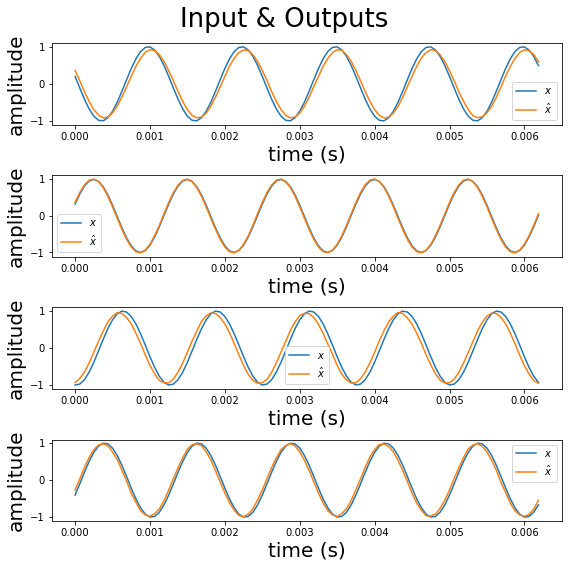

In [3]:

predictor = predict.Prediction(cfg['model'], model_save_path, **cfg['training'])
inputs = [x.numpy() for x in test_loader]
results = predictor.predict(test_loader)
visualize_signal_pairs(t, inputs, results)
